# Домашнее задание 

В этом задании мы попрактикуемся в методах снижения размерности и кластеризации данных. 

## Задание 1. Кластеризация типов движений (5 баллов)

В этой части задания мы будем работать с набором данных Samsung Human Activity Recognition. Скачайте данные по ссылке https://yadi.sk/d/_WFxgSIuBF06Rg. Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3, также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице.

Представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков.

Также есть методичка/овервью от sklearn:
[Методичка](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction import image as img
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import (KMeans, AgglomerativeClustering, MeanShift, estimate_bandwidth, 
                             FeatureAgglomeration, spectral_clustering)
from sklearn.metrics import adjusted_rand_score, v_measure_score, silhouette_score
from matplotlib import pyplot as plt


plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

%matplotlib inline
%config InlineBackend.figure_format="retina"

RANDOM_STATE = 42

### Задание 1.0 (0.1 балл)
Прочитайте данные из файлов и объедните тестовую и обучающие выборки.

В файлах ```..._labels``` лежат настоящие классы. Их также объедините, но в отдельную переменную (например ```y```). Данный вектор для кластеризации нам не нужен, но мы будем смотреть по нему метрики.

In [5]:
#your code here
X_train = np.loadtxt('samsung_HAR/samsung_train.txt')
X_test = np.loadtxt('samsung_HAR/samsung_test.txt')

y_train = np.loadtxt('samsung_HAR/samsung_train_labels.txt')
y_test = np.loadtxt('samsung_HAR/samsung_test_labels.txt')

X = np.vstack([X_train, X_test])
y = np.hstack([y_train, y_test])

In [6]:
np.unique(y)

array([1., 2., 3., 4., 5., 6.])

Эти метки соответствуют:

1 - ходьбе,
2 - подъему вверх по лестнице,
3 - спуску по лестнице,
4 - сидению,
5 - стоянию,
6 - лежанию

### Задание 1.1 (0.5 баллов)

Отмасштабируйте выборку с помощью ```StandardScaler```.

[Документация](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

In [7]:
#your code here
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Задание 1.2 (0.6 баллов)

Понизьте размерность с помощью ```PCA```, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии отмасштабированных данных. ```random_state``` используйте из объявленной в самом начале переменной ```RANDOM_STATE``` (42).

[Документация](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

In [8]:
for n_components in range(5, 500):
    pca = PCA(n_components=n_components, random_state=RANDOM_STATE)
    X_pca = pca.fit_transform(X)
    if pca.explained_variance_ratio_.sum() >= 0.9:
        break

In [41]:
pca.explained_variance_ratio_.sum()

0.902141449462932

### Задание 1.3 (0.3 баллов)

Визуализируйте данные в проекции на первые две главные компоненты. Используйте ```cmap="virdis"``` или любой другой, с которым будет красиво :)

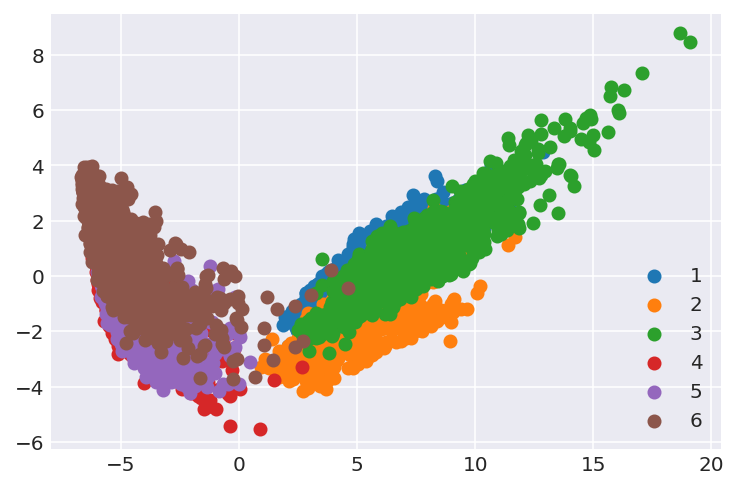

In [10]:
for target in zip(np.unique(y)):
    plt.scatter(X_pca[y==target, 0], X_pca[y==target, 1], cmap='virdis')
    
plt.legend(list(map(int, np.unique(y))))

### Задание 1.4 (0.4 балла)

Сделайте кластеризацию данных методом ```KMeans```, обучив модель на данных со сниженной за счет ```PCA```
размерностью. В данном случае нужно искать 6 кластеров (изначально у нас 6 классов). Засеките время обучения и время инференса.

Параметры:

```n_clusters = 6``` (число уникальных меток целевого класса = 6)

```n_init = 100```

```random_state = RANDOM_STATE``` (для воспроизводимости результата, не забывайте указывать его и дальше!)

[Документация](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

In [11]:
%%time
kmeans = (KMeans(n_clusters=6, n_init=100, random_state=RANDOM_STATE)
          .fit(X_pca))

CPU times: user 9.56 s, sys: 3.65 s, total: 13.2 s
Wall time: 1.79 s


### Задание 1.5 (0.2 балла)

Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

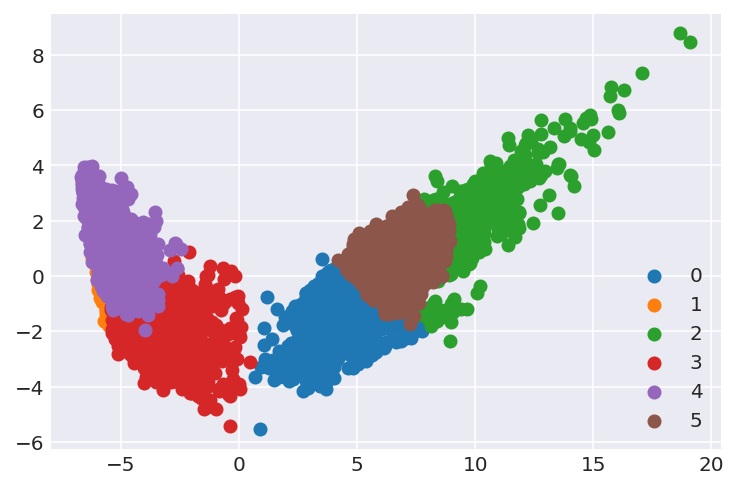

In [12]:
for pred in zip(np.unique(kmeans.labels_)):
    plt.scatter(X_pca[kmeans.labels_==pred, 0], X_pca[kmeans.labels_==pred, 1], cmap='virdis')
    
plt.legend(list(map(int, np.unique(kmeans.labels_))))

### Задание 1.6 (0.3 баллов)

Выберите какие-то метрики (минимум две) из известных вам или из методички (ссылка в начале дз, пункт 2.3.10), объясните ваш выбор.

Выведите на экран значения метрик качества кластеризации и используйте их далее.

In [13]:
adjusted_rand_score(y, kmeans.labels_)

0.4612418475053482

In [14]:
v_measure_score(y, kmeans.labels_)

0.5887394577451389

In [15]:
silhouette_score(X_pca, kmeans.labels_, metric='euclidean')

0.17373672890470512

#### Выбрал метрики adjusted_rand_score и v_measure_score, поскольку у нас есть истинные классы в этой задаче, и эти метрики показывают, как хорошо модель разделяет данные на кластеры, соответствующие реальным классам. Также выбрал метрику silhouette_score, которая без меток классов показывает, насколько хорошо данные разделились на классы с точки зрения расстояний между объектами кластеров, для таких форм истинных кластеров она наверное не очень хорошо подходит, интересно будет посмотреть на нее в сравнении с другими подходами

### Задание 1.7 (0.8 баллов)
Теперь попробуем сделать кластеризацию с помощью ```AgglomerativeClustering```.

Вновь визуализируйте данные с раскраской по полученным меткам и выведите метрики. Засеките время обучения и время инференса. Сравните с ```KMeans```.

Ответьте на следующие вопросы:
* Стало ли лучше?
* Почему?

[Документация](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)

In [16]:
%%time
aggl_clust = (AgglomerativeClustering(n_clusters=6)
              .fit(X_pca))

CPU times: user 4.37 s, sys: 321 ms, total: 4.69 s
Wall time: 4.73 s


In [17]:
adjusted_rand_score(y, aggl_clust.labels_)

0.4737952666183192

In [18]:
v_measure_score(y, aggl_clust.labels_)

0.6180485123615865

In [19]:
silhouette_score(X_pca, aggl_clust.labels_, metric='euclidean')

0.1602128946610696

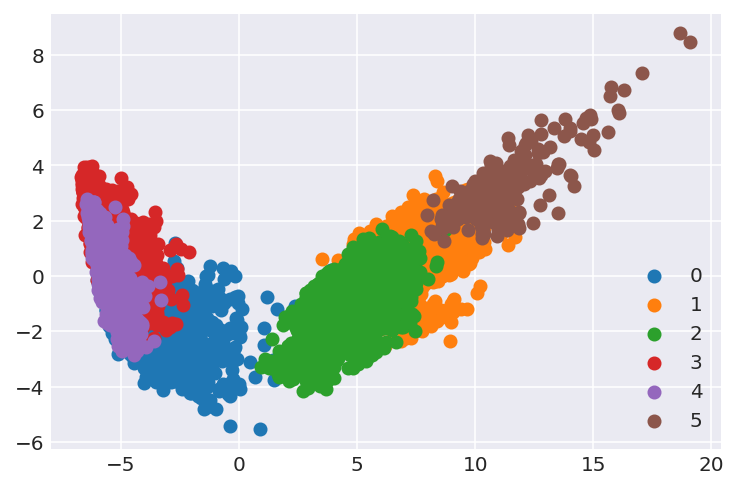

In [20]:
for pred in zip(np.unique(aggl_clust.labels_)):
    plt.scatter(X_pca[aggl_clust.labels_==pred, 0], X_pca[aggl_clust.labels_==pred, 1], cmap='virdis')
    
plt.legend(list(map(int, np.unique(aggl_clust.labels_))))

#### adjusted_rand_score и v_measure_score стали чуть лучше, silhouette_score немного ухудшился. Получается классы определяем лучше, но их форма не такая хорошая для silhouette_score

### Задание 1.8 (0.8 баллов)

Попробуйте применить другие методы кластеризации из sklearn.  Засеките время обучения и время инференса. Также вычислите метрики качества, визуализируйте результаты, после чего сделайте вывод о том, какой метод сработал лучше.

### mean shift

In [21]:
%%time
bandwidth = estimate_bandwidth(X_pca, quantile=0.0037, n_jobs=-1)
mean_shift_clust = (MeanShift(bandwidth=bandwidth, bin_seeding=True)
             .fit(X_pca))

CPU times: user 22.2 s, sys: 11.7 s, total: 33.9 s
Wall time: 4.57 s


In [22]:
adjusted_rand_score(y, mean_shift_clust.labels_)

0.5450446863127507

In [23]:
v_measure_score(y, mean_shift_clust.labels_)

0.6283593410609041

In [24]:
silhouette_score(X_pca, mean_shift_clust.labels_, metric='euclidean')

0.17302471211386453

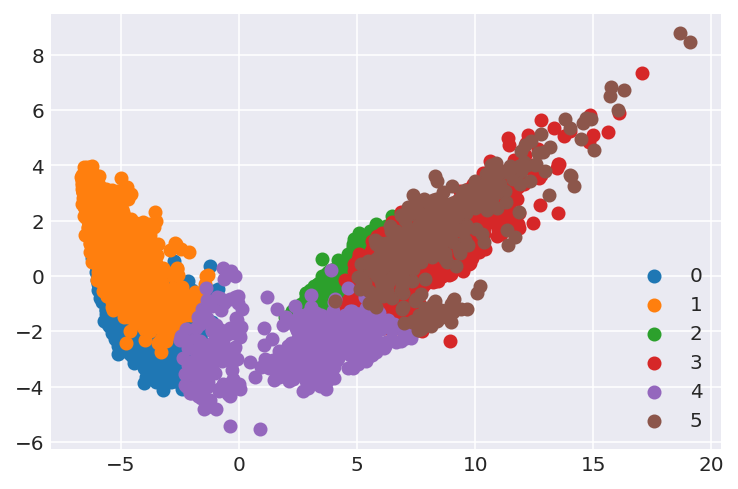

In [25]:
for pred in zip(np.unique(mean_shift_clust.labels_)):
    plt.scatter(X_pca[mean_shift_clust.labels_==pred, 0], X_pca[mean_shift_clust.labels_==pred, 1], cmap='virdis')
    
plt.legend(list(map(int, np.unique(mean_shift_clust.labels_))))

In [26]:
mean_shift_clust.labels_

array([0, 0, 0, ..., 2, 2, 2])

#### mean shift сработал лучше остальных, однако он сам выбирает число кластеров, поэтому для него пришлось подбирать параметры bandwidth для выбора 6 кластеров. 

### Задание 1.9 (1 балл)
Для самой успешной из полученных кластеризаций попробуйте дать интерпретацию кластеров. Опишите характеристики объектов, попавших в каждый кластер. Для этого можете ответить на следующие вопросы:

* Похожи ли объекты внутри каждого кластера на определенный тип активности человека?
* В каких кластерах смешано несколько типов активности? С чем, на ваш взгляд, это может быть связано?
* Качественная ли получилась кластеризация? На основании чего вы можете сделать такой вывод?

#### Видно, что все классы разделены на две группы и "накладываются" друг на друга внутри этих групп, видимо группы - это неподвижность (стоит, лежит, сидит) и движение (ходит, идет вверх/вниз по лестнице). Наши получившиеся кластеры тоже разделены на 2 группы, визуально видно, что внутри самих кластеров объекты могут быть классифицированы неправильно, но глобальные группы движения и неподвижности классифицируются отлично

## Задание 2. Разделение изображения на семантические компоненты (5 баллов)

![RedPanda](http://imgur.com/6Aa52Lm.png)

Алгоритмы кластеризации могут применяться в самых разных задачах. Например, в анализе изображений есть задача разделения изображения на семантические компоненты, которую можно решать в том числе с помощью алгоритмов кластеризации. 

Проверим их на ```duck.jpg``` и ```owls.jpg```

### Задание 2.0 (0.1 балл)

Откройте изображения, после чего визуализируйте их с помощью ```plt.imshow()```

In [3]:
from PIL import Image, ImageOps, ImageFilter
# or 
#import cv2

duck = Image.open('duck.jpeg')
owl = Image.open('owl.jpeg')

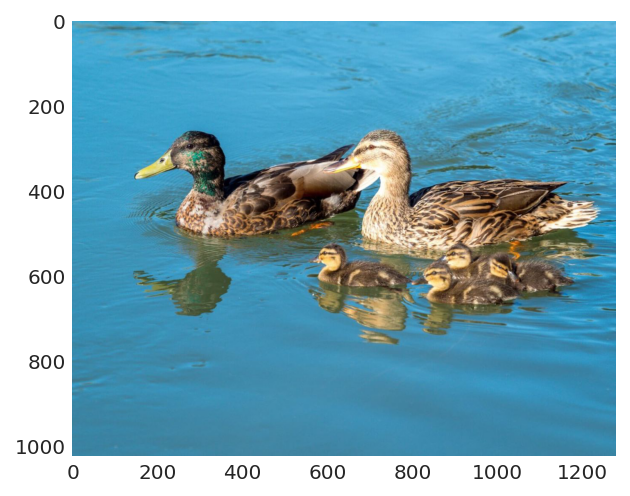

In [129]:
plt.imshow(duck)
plt.grid(None)

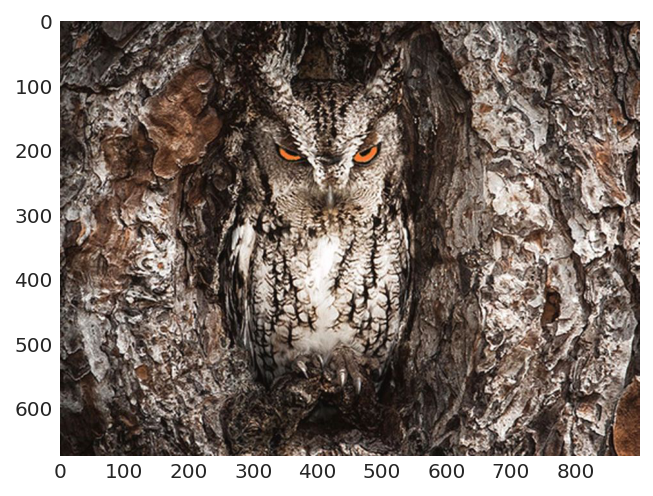

In [130]:
plt.imshow(owl)
plt.grid(None)

### Задание 2.1 (1.5 балла)
Для каждого изображения, используя кластеризацию ```KMeans```, выделите компоненты, охарактеризовав каждый пиксель следующим образом: $\psi_i = [\lambda x_i, \lambda y_i, r_i, g_i, b_i]$, где 
$x_i$ и $y_i$ — координаты пикселя, $r_i, g_i, b_i$ — его цвет, $\lambda$ — параметр, выражающий важность пространственной связности перед цветовой похожестью.

Примените полученную функцию, взяв следующие $\lambda$: 0.3 и 1.5 для ```duck.jpg``` и ```owls.jpg``` (или другие, но тогда с вас красивые результаты :) )

Число кластеров подберите разумным образом на свой вкус (в качестве нулевого приближения можно взять 3)

In [97]:
def find_components(image, lmbd, n_clusters):
    data = np.array(image)
    X = []
    for y in range(data.shape[0]):
        for x in range(data.shape[1]):
            X.append((lmbd * x, lmbd * y, data[y, x, 0], data[y, x, 1], data[y, x, 2]))
            
    X = np.array(X)
    kmeans = KMeans(n_clusters=n_clusters).fit(X)
    return kmeans

/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


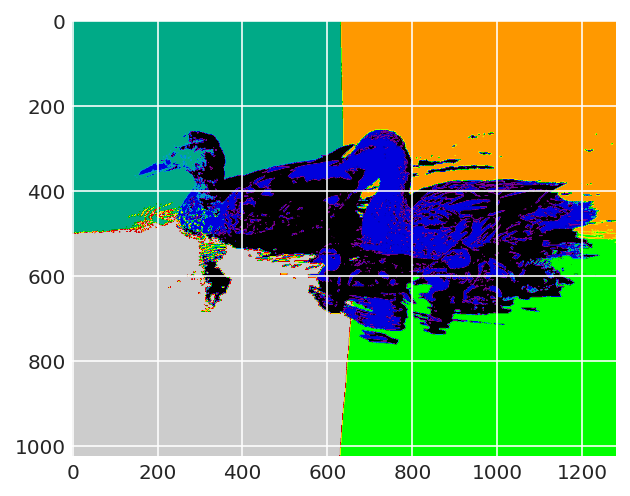

In [324]:
duck_kmeans = find_components(duck, 0.3, 6)
duck_labels = duck_kmeans.labels_.reshape(np.array(duck).shape[:2])
plt.imshow(duck_labels, cmap='nipy_spectral_r')

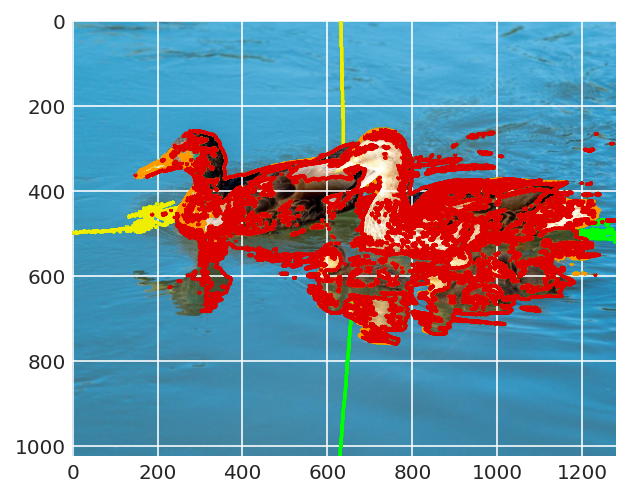

In [360]:
plt.imshow(duck)
for label in np.unique(duck_labels):
    plt.contour(duck_labels==label, 
                colors=[plt.cm.nipy_spectral((label + 4) / float(len(np.unique(duck_labels)) + 4))])

#### при 6 кластерах у совы интересно отобразились глаза:)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


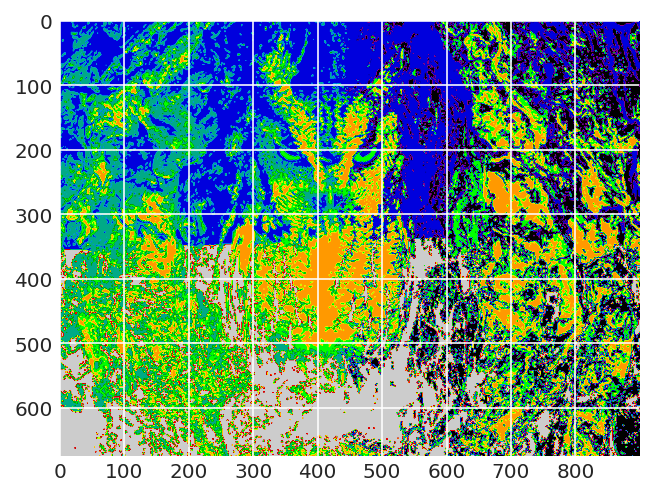

In [328]:
owl_kmeans = find_components(owl, 0.15, 6)
owl_labels = owl_kmeans.labels_.reshape(np.array(owl).shape[:2])
plt.imshow(owl_labels, cmap='nipy_spectral_r')

/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


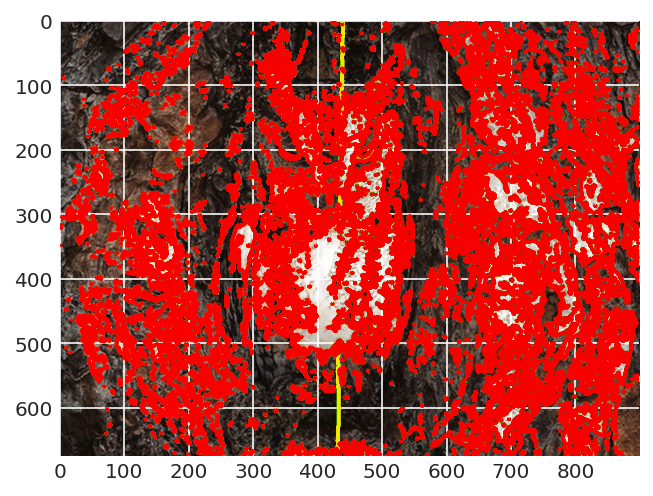

In [148]:
owl_kmeans = find_components(owl, 0.4, 3)
owl_labels = owl_kmeans.labels_.reshape(np.array(owl).shape[:2])

plt.imshow(owl)
for label in np.unique(owl_labels):
    plt.contour(owl_labels==label, 
                colors=[plt.cm.nipy_spectral((label + 4) / float(len(np.unique(owl_labels)) + 4))])

### Сделал визуализации как контуров кластеров, так и самих кластеров, для совы красивее получился второй вариант 

### Задание 2.2 (1.5 балла)
Попробуйте выделить сегменты при помощи [спектральной кластеризации](http://scikit-learn.org/stable/modules/clustering.html#spectral-clustering). Обратите внимание на [пример в sklearn](http://scikit-learn.org/0.16/auto_examples/cluster/plot_lena_segmentation.html). Для ускорения работы алгоритма рекомендуется привести изображение к серому цвету. При необходимости можно сжать изображения в 2 раза.

Подсказка: ```skimage``` с его ```color``` и ```transform``` в этом помогут :)

Или же воспользуйтесь аналогичными средствами ```PIL``` или ```cv2``` 

In [3]:
duck_gray = ImageOps.grayscale(duck)
owl_gray = ImageOps.grayscale(owl)

In [72]:
def spectral_segmentation(image, n_clusters, beta, eps, assign_labels):
    graph = img.img_to_graph(np.array(image))
    graph.data = np.exp(-beta * graph.data / np.array(image).std()) + eps
    res = spectral_clustering(graph, n_clusters=n_clusters, eigen_solver='amg')

    labels = res.reshape(np.array(image).shape)
    return labels

### Задание 2.3 (0.9 баллов)
Визуализируйте результаты сегментации (аналогично рисунку в начале задания 2) для обоих методов.

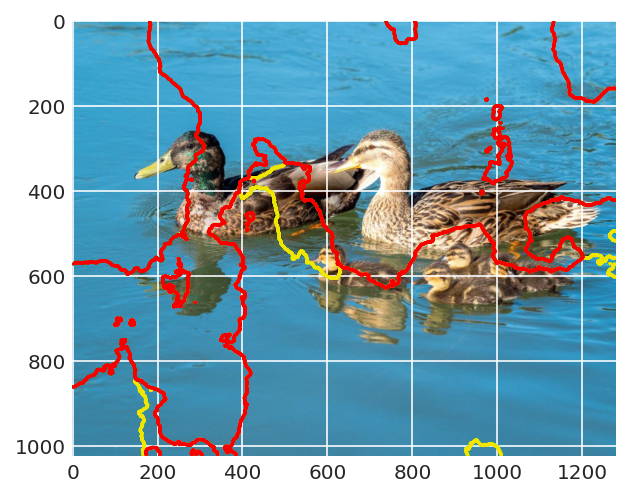

In [74]:
image = duck_gray
beta = 1
eps = 2
n_clusters = 3
assign_labels = 'kmeans'

res = spectral_segmentation(image=image, n_clusters=n_clusters, beta=beta, eps=eps, assign_labels=assign_labels)

plt.imshow(duck)

duck_labels = res.reshape(np.array(image).shape)

for label in np.unique(duck_labels):
    plt.contour(duck_labels==label, 
                colors=[plt.cm.nipy_spectral((label + 4) / float(len(np.unique(duck_labels)) + 4))])

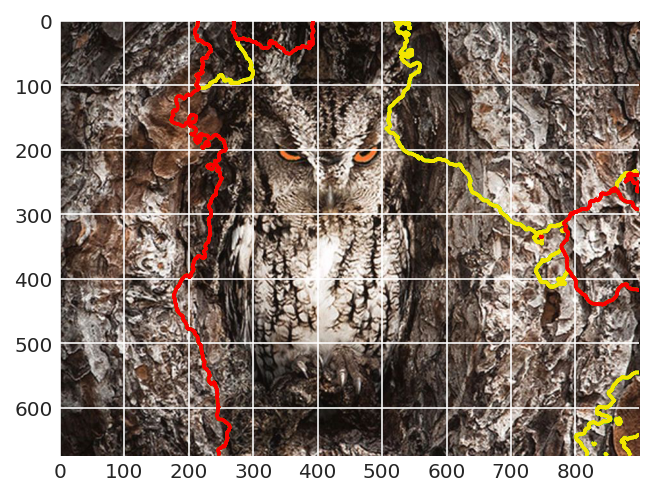

In [86]:
image = owl_gray
beta = 1
eps = 2
n_clusters = 3
assign_labels = 'kmeans'

res = spectral_segmentation(image=image, n_clusters=n_clusters, beta=beta, eps=eps, assign_labels=assign_labels)

plt.imshow(owl)

owl_labels = res.reshape(np.array(image).shape)

for label in np.unique(owl_labels):
    plt.contour(owl_labels==label, 
                colors=[plt.cm.nipy_spectral((label + 4) / float(len(np.unique(owl_labels)) + 4))])

### Задание 2.4 (1 балл)
Найдите интересную картинку милого животного и примените алгоритмы и к ней. Поэкспериментируйте с параметрами алгоритмов. Картинку нужно будет загрузить вместе с работой. Слишком большие лучше не брать - считаться будет долго. Не забудьте визуализировать!

Сравните два подхода и сегментации, к которым они приводят.
Для всех ли изображений в результате сегментации хорошо видны контуры объектов?

In [87]:
#your code here

richie = Image.open('richie.jpeg')

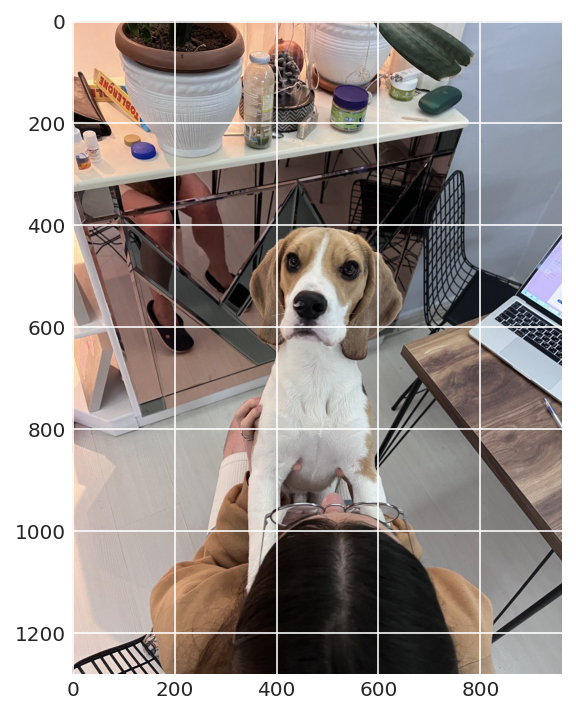

In [93]:
fig = plt.figure(figsize=(8, 6))
plt.imshow(richie)

In [94]:
richie_gray = ImageOps.grayscale(richie)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


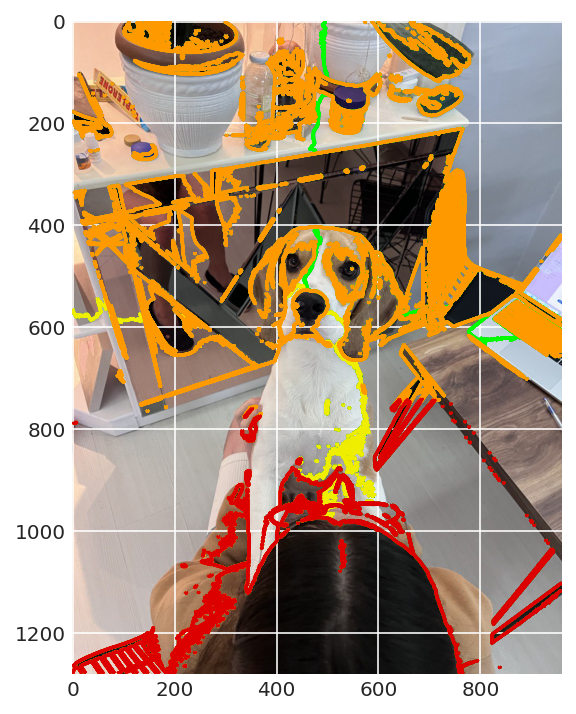

In [115]:
richie_kmeans = find_components(richie, 0.45, 6)
richie_labels = richie_kmeans.labels_.reshape(np.array(richie).shape[:2])
fig = plt.figure(figsize=(8, 6))

plt.imshow(richie)
for label in np.unique(richie_labels):
    plt.contour(richie_labels==label, 
                colors=[plt.cm.nipy_spectral((label + 4) / float(len(np.unique(richie_labels)) + 4))])

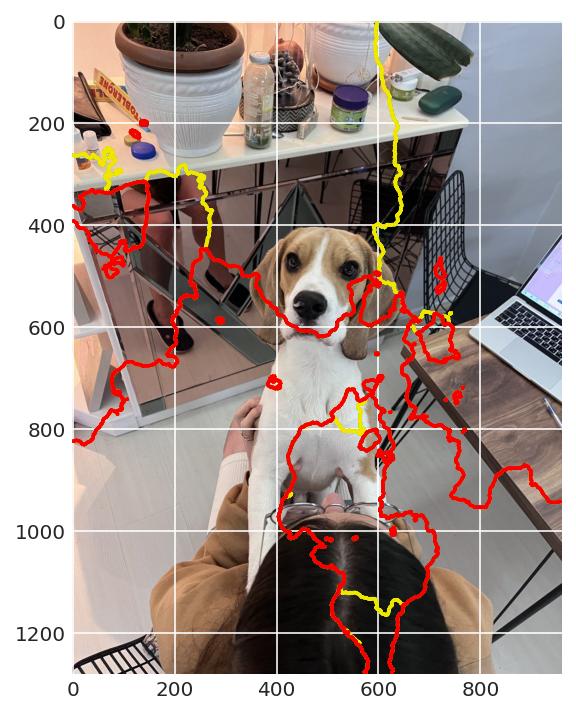

In [126]:
image = richie_gray
beta = 1
eps = 2
n_clusters = 3
assign_labels = 'kmeans'

res = spectral_segmentation(image=image, n_clusters=n_clusters, beta=beta, eps=eps, assign_labels=assign_labels)

fig = plt.figure(figsize=(8, 6))
plt.imshow(richie)

richie_labels = res.reshape(np.array(image).shape)

for label in np.unique(richie_labels):
    plt.contour(richie_labels==label, 
                colors=[plt.cm.nipy_spectral((label + 4) / float(len(np.unique(richie_labels)) + 4))])

###  Спектральная сегментация плохо получилась на всех картинках, подход с Kmeans работает гораздо лучше в этой задаче

# Акция
Повеселите проверяющего и вставьте смешной мем. Вдруг повысят балл! Или разместите ваше сообщение о продаже гаража здесь.

[Методичка по мемам](https://www.youtube.com/watch?v=dQw4w9WgXcQ)

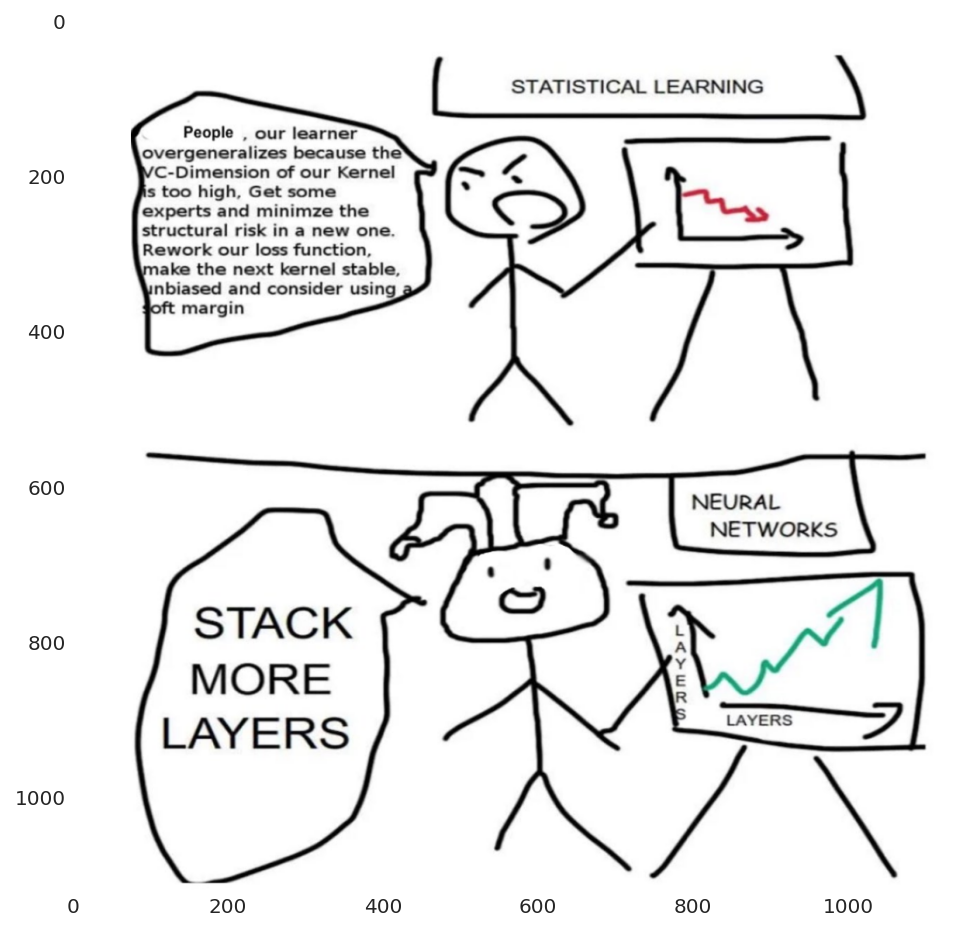

In [4]:
meme = Image.open('mem.png')

fig = plt.figure(figsize=(10, 8))

plt.imshow(meme)
plt.grid(None)